# Data Analytics Project
- Project Name: Revenue VatVisual
- Team Name: Best TeamName = None
- Team Member: 

##  Data Visualization
Using the dataset from kaggle, we are performing a googlestore customer behavior and revenue analytics. In the data visualizatio part, we aims to analyze google store's customer behavior. There are two main questions that we are trying to answer:

1. what group of people generate the most reveune?
2. Where do our customer come from?

### Part I: Data Cleansing

#### 1. Read the Data

In [1]:
# Necessary librarys
import os # it's a operational system library, to set some informations
import random # random is to generate random values

import pandas as pd # to manipulate data frames 
import numpy as np # to work with matrix
from scipy.stats import kurtosis, skew # it's to explore some statistics of numerical values

import matplotlib.pyplot as plt # to graphics plot
import seaborn as sns # a good library to graphic plots
import squarify # to better understand proportion of categorys - it's a treemap layout algorithm

# Importing librarys to use on interactive graphs
from plotly.offline import init_notebook_mode, iplot, plot 
import plotly.graph_objs as go 

import json # to convert json in df
from pandas.io.json import json_normalize # to normalize the json file

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import *
import plotly.tools as tools

# to set a style to all graphs
plt.style.use('fivethirtyeight')
init_notebook_mode(connected=True)

#### 2. Extract multiple information to seperate columns
In our original file, some of the columns contain multiple subcolumns and are formated in JSON type. We define a function to flattern these subcolumns and attached then to dataframe.

For example, Json column 'device' may contains multiple information such as: browser, browsersize... We flattern these columns as device.browser, device.browsersize as subcolumns of the dataframe.

In [2]:
def load_df(csv_path, JSON_COLUMNS):

    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'})
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

    return df

df_train = load_df(csv_path='train.csv', JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource'])

#### 3. Missing Value Analysis 

In [3]:
def missing_values(data):
    total = data.isnull().sum().sort_values(ascending = False) # getting the sum of null values and ordering
    percent = (data.isnull().sum() / data.isnull().count() * 100 ).sort_values(ascending = False) #getting the percent and order of null
    df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) # Concatenating the total and percent
    print (df[~(df['Total'] == 0)]) # Returning values of nulls different of 0
    print("\nTotal of Sales % of Total: ", round((df_train[df_train['totals.transactionRevenue'] != np.nan]['totals.transactionRevenue'].count() / len(df_train['totals.transactionRevenue']) * 100),4))
    return 

In [4]:
# calling the missing values function
missing_values(df_train) 

                                               Total    Percent
trafficSource.campaignCode                    903652  99.999889
trafficSource.adContent                       892707  98.788694
totals.transactionRevenue                     892138  98.725728
trafficSource.adwordsClickInfo.page           882193  97.625195
trafficSource.adwordsClickInfo.adNetworkType  882193  97.625195
trafficSource.adwordsClickInfo.slot           882193  97.625195
trafficSource.adwordsClickInfo.isVideoAd      882193  97.625195
trafficSource.adwordsClickInfo.gclId          882092  97.614018
trafficSource.isTrueDirect                    629648  69.678073
trafficSource.referralPath                    572712  63.377425
trafficSource.keyword                         502929  55.655102
totals.bounces                                453023  50.132407
totals.newVisits                              200593  22.198012
totals.pageviews                                 100   0.011066

Total of Sales % of Total:  1.2743


#### 4. Datetime object transformation

In [5]:
# This function is to extract date features
def date_process(df):
    from datetime import datetime
    import datetime as dt
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d") # seting the column as pandas datetime
    df["weekday"] = df['date'].dt.weekday #extracting week day
    df["day"] = df['date'].dt.day # extracting day
    df["month"] = df['date'].dt.month # extracting day
    df["year"] = df['date'].dt.year # extracting day
    df['visitHour'] = (df['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)
    return df

In [6]:
df_train = date_process(df_train) #calling the function that we created above

In [8]:
#overview of our dataframe
df_train.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,weekday,day,month,year,visitHour
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,(not provided),organic,NaN,google,4,2,9,2016,11
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,(not provided),organic,NaN,google,4,2,9,2016,1
2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,(not provided),organic,NaN,google,4,2,9,2016,21
3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,NaN,google + online,organic,NaN,google,4,2,9,2016,1
4,Organic Search,2016-09-02,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,True,(not provided),organic,NaN,google,4,2,9,2016,9


### PartII: Data Visualization

#### genral information
Just to have a general sense of the googlestore customers, we count the number of paying customers in the dataframe. Now we are able to see how many non-zero transactions each customer has performed within the timeframe (based on their fullVisiorId).

As stated below, <span style="color:red">less than 1.5%</span> of all vistors of google store are actual buyers. The rest of them are jusy browsing, but not buying anything.

Among actual buyers, the most frequent buyer has 33 transactions (with fullVisiorId 7813149961404844386). We also listed the top 10 frequent buyers

In [9]:
#counts define the number of the paying customers
for col in ['visitNumber', 'totals.hits', 'totals.pageviews', 'totals.transactionRevenue']:
    df_train[col] = df_train[col].astype(float)
counts = df_train.loc[df_train['totals.transactionRevenue'] > 0, 'fullVisitorId'].value_counts()
print('There are {0} paying users ({1} total) in train data.'.format(len(counts), df_train['fullVisitorId'].nunique()))
print('{0} users ({1:.4f}% of paying) have 1 paid transaction.'.format(np.sum(counts == 1), 100 * np.sum(counts == 1) / len(counts)))
print('{0} users ({1:.4f}% of paying) have 2 paid transaction.'.format(np.sum(counts == 2), 100 * np.sum(counts == 2) / len(counts)))
print('')
print('Count of top 10 non-zero transactions per user: [fullVisitorId: numbers of total transactions]')
counts.head(10)

There are 9996 paying users (714167 total) in train data.
9029 users (90.3261% of paying) have 1 paid transaction.
714 users (7.1429% of paying) have 2 paid transaction.

Count of top 10 non-zero transactions per user: [fullVisitorId: numbers of total transactions]


7813149961404844386    33
1957458976293878100    16
4984366501121503466    16
6760732402251466726    15
2402527199731150932    15
0608915197735218105    13
7311242886083854158    12
9089132392240687728    10
8197879643797712877    10
9029794295932939024     9
Name: fullVisitorId, dtype: int64

#### 1. pie chart: transaction for  buying customer
From the piechart we can see that, googlestore do not have many frequent buyers. Up to 97% of the buying customers are only one time, or two time buyers.

📌note: since we use ploty to generate our result, the picture can not be shown unless you run the code 

📌We have the screenshot attached, and the url link (https://plot.ly/~yz3152/6) to see the animiation version of our picture.

📌Please feel free to click and see details of our visualization!

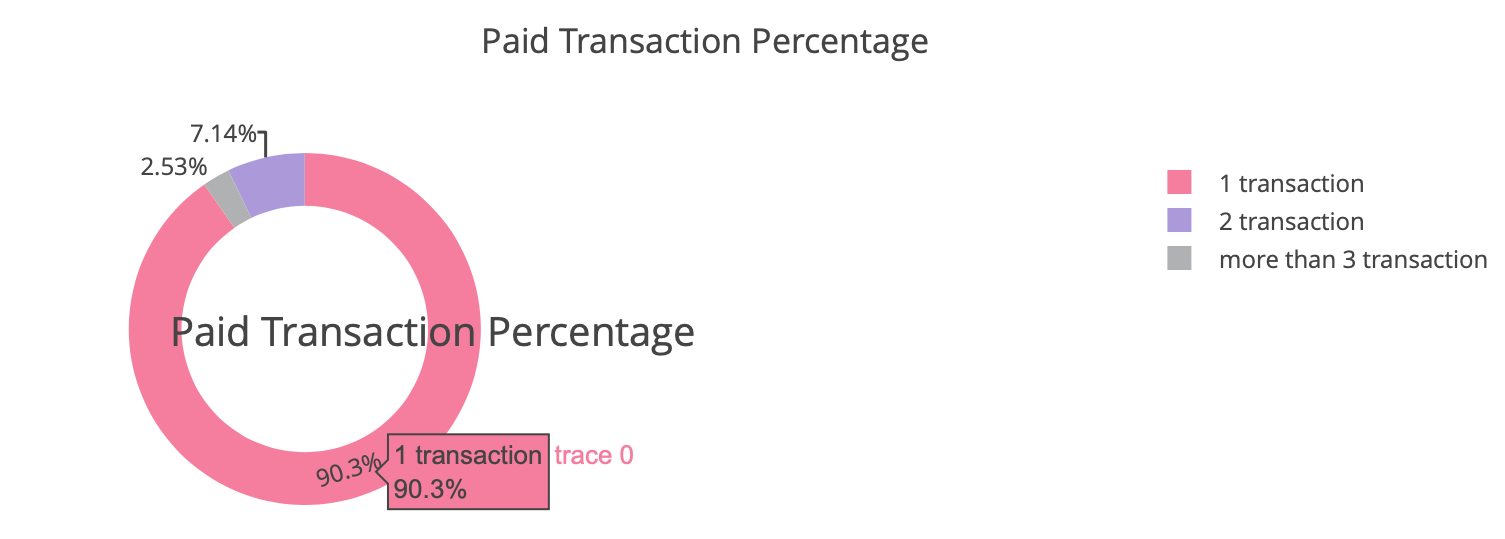

In [10]:
from PIL import Image
import requests
from io import BytesIO
url="https://i.imgsafe.org/84/844c4c0297.png"
response = requests.get(url)
img1 = Image.open(BytesIO(response.content))
img1

In [11]:
# pie chart code 
paidtransactionindex = ['1 transaction','2 transaction','more than 3 transactions']

paidtransactionvalue = [9029,714,253]

domain1 = {'x': [0.2, 0.50], 'y': [0.0, 0.33]}
fig = {
  "data": [
    {
      "values": paidtransactionvalue,
      "labels": paidtransactionindex,
      "domain": {"x": [0, .48]},
    "marker" : dict(colors=["#f77b9c" ,'#ab97db',  '#b0b1b2']),
      "hoverinfo":"label+percent+name",
      "hole": .7,
      "type": "pie"
    }
   ],
  "layout": {"title":"Paid Transaction Percentage",
      "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Paid Transaction Percentage",
                "x": 0.11,
                "y": 0.5
            }
        ]
    }
}
iplot(fig)

#### 2. distribution of log revenue 
we are using log revenue for analytics, since Kaggle requires perdicted log revenue per customer.

Also, the log reveune is more naturally distributed in graph

As the two graphs depicted, the customers who buys things in google store will buy a lot.

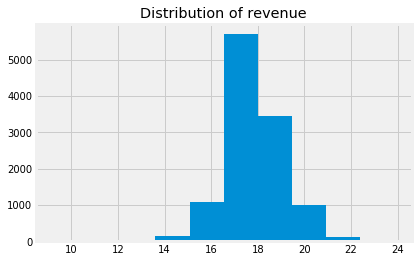

In [12]:
# Plot distribution of log total revenue (without summing up each visitor's transaction)
plt.hist(np.log1p(df_train.loc[df_train['totals.transactionRevenue'].isna() == False, 'totals.transactionRevenue']));
plt.title('Distribution of revenue');

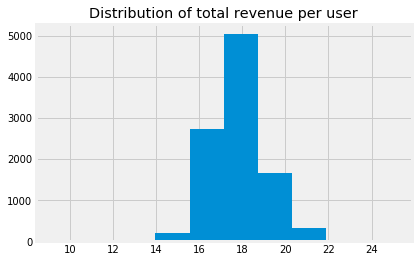

In [13]:
# Plot distribution of log total revenue per user (grouped by visitor ID)
grouped = df_train.groupby('fullVisitorId')['totals.transactionRevenue'].sum().reset_index()
grouped = grouped.loc[grouped['totals.transactionRevenue'].isna() == False]
plt.hist(np.log(grouped.loc[grouped['totals.transactionRevenue'] > 0, 'totals.transactionRevenue']));
plt.title('Distribution of total revenue per user');

#### 3. Geonetwork Analysis: World map of global customer visit distribution and purchase distribution
Comparing visit distribution and purchase distribution, we can see that Googlestore has visitors all around the world. Most visit countries include <b>United States, Canada and India</b>. However, most of the buyers are from <b>United States</b>

📌note: since we use ploty to generate our result, the picture can not be shown unless you run the code 

📌We have the screenshot attached, and the url link (https://plot.ly/~yz3152/8) (https://plot.ly/~yz3152/10) to see the animiation version of our picture.

📌Please feel free to click and see details of our visualization!

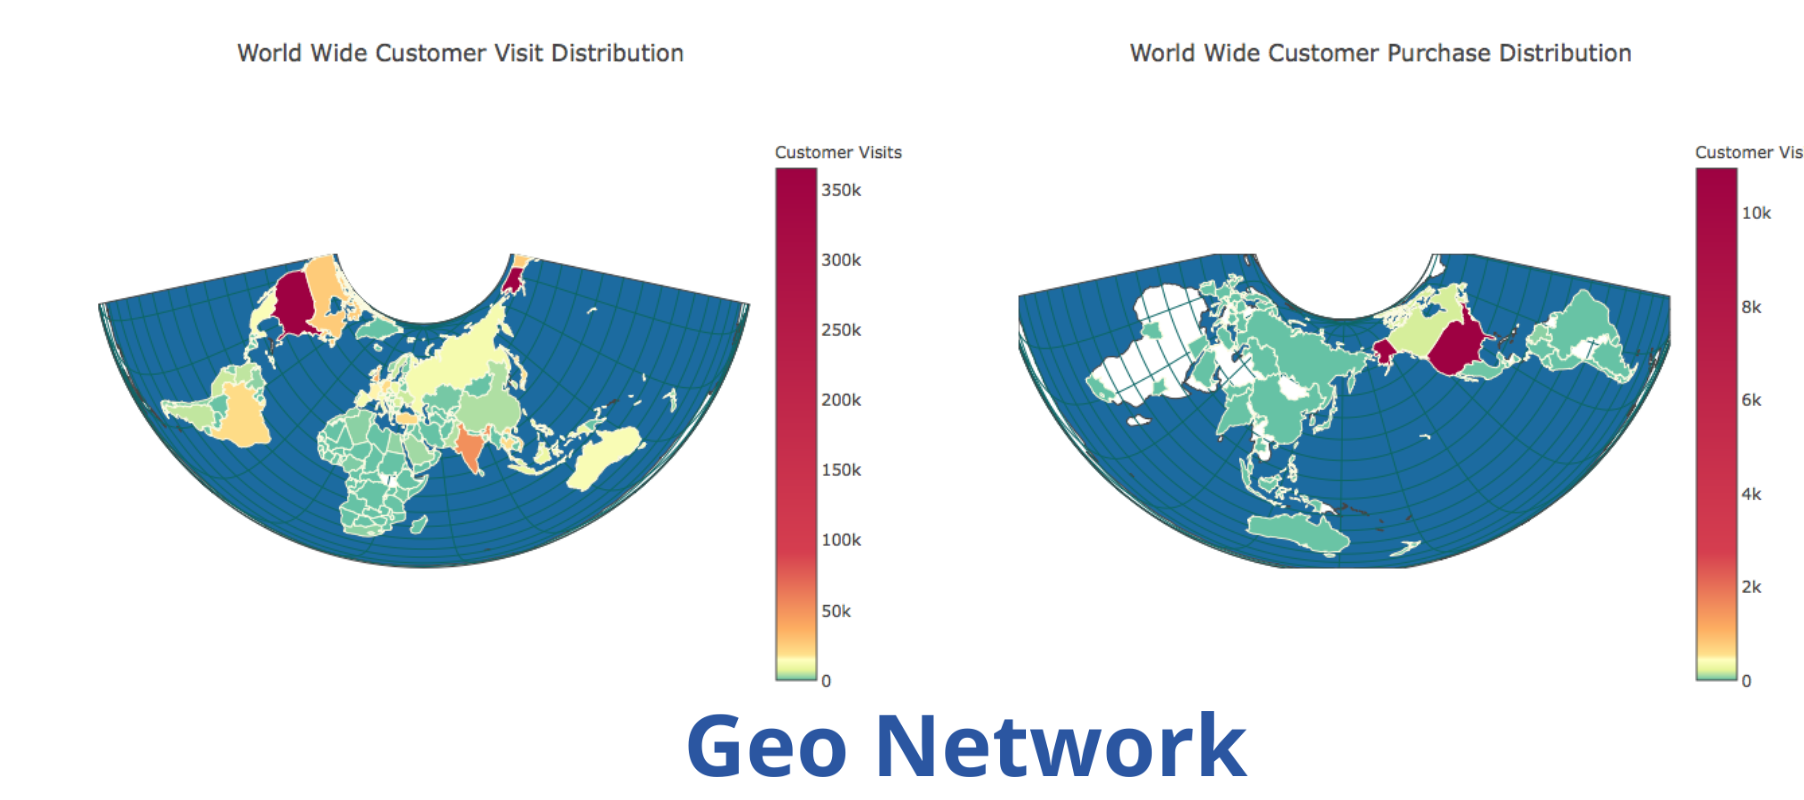

In [14]:
from PIL import Image
import requests
from io import BytesIO
url="https://i.imgsafe.org/85/85736892c2.png"
response = requests.get(url)
img2 = Image.open(BytesIO(response.content))
img2

In [15]:
# Code for Plotting the global customer visit distribution for each country
colorscale = [[0, 'rgb(102,194,165)'], [0.0005, 'rgb(102,194,165)'], 
              [0.01, 'rgb(171,221,164)'], [0.02, 'rgb(230,245,152)'], 
              [0.04, 'rgb(255,255,191)'], [0.05, 'rgb(254,224,139)'], 
              [0.10, 'rgb(253,174,97)'], [0.25, 'rgb(213,62,79)'], [1.0, 'rgb(158,1,66)']]

data = [ dict(
        type = 'choropleth',
        autocolorscale = False,
        colorscale = colorscale,
        showscale = True,
        locations = df_train["geoNetwork.country"].value_counts().index,
        locationmode = 'country names',
        z = df_train["geoNetwork.country"].value_counts().values,
        marker = dict(
            line = dict(color = 'rgb(250,250,225)', width = 1)),
            colorbar = dict( title = 'Customer Visits ')
            ) 
       ]

layout = dict(
    height=600,
    title = 'World Wide Customer Visit Distribution',
    geo = dict(
        showframe = True,
        showocean = True,
        oceancolor = 'rgb(28,107,160)',
        projection = dict(
        type = 'orthographic',
            rotation = dict(
                    lon = 50,
                    lat = 10),
        ),
        lonaxis =  dict(
                showgrid = True,
                gridcolor = 'rgb(12, 102, 102)'
            ),
        lataxis = dict(
                showgrid = True,
                gridcolor = 'rgb(12, 102, 102)'
                )
            ),
        )
fig = dict(data=data, layout=layout)
iplot(fig)

In [16]:
# Code for Plotting the global customer purchase distribution for each country
colorscale = [[0, 'rgb(102,194,165)'], [0.0005, 'rgb(102,194,165)'], 
              [0.01, 'rgb(171,221,164)'], [0.02, 'rgb(230,245,152)'], 
              [0.04, 'rgb(255,255,191)'], [0.05, 'rgb(254,224,139)'], 
              [0.10, 'rgb(253,174,97)'], [0.25, 'rgb(213,62,79)'], [1.0, 'rgb(158,1,66)']]

data = [ dict(
        type = 'choropleth',
        autocolorscale = False,
        colorscale = colorscale,
        showscale = True,
        locations = df_train[df_train['totals.transactionRevenue']>0]["geoNetwork.country"].value_counts().index,
        locationmode = 'country names',
        z = df_train[df_train['totals.transactionRevenue']>0]["geoNetwork.country"].value_counts().values,
        marker = dict(
            line = dict(color = 'rgb(250,250,225)', width = 1)),
            colorbar = dict( title = 'Customer Visits ')
            ) 
       ]

layout = dict(
    height=600,
    title = 'World Wide Customer Purchase Distribution',
    geo = dict(
        showframe = True,
        showocean = True,
        oceancolor = 'rgb(28,107,160)',
        projection = dict(
        type = 'conic equal area',
            rotation = dict(
                    lon = 50,
                    lat = 10),
        ),
        lonaxis =  dict(
                showgrid = True,
                gridcolor = 'rgb(12, 102, 102)'
            ),
        lataxis = dict(
                showgrid = True,
                gridcolor = 'rgb(12, 102, 102)'
                )
            ),
        )
fig = dict(data=data, layout=layout)
iplot(fig)

#### 4. Traffic Source Analysis
We are trying to see how different sources of traffic will influence revenue of google stores.

We can see that, when comparing visitors and actual buyers, most of them are from google.com. Buyers are more likely to make purcahse because they received email notification from gstore.

In terms of mean reveue, factors like dfa (Doubleclik For Avertisers) ans cpa (Cost per action) are really high. Maybe marketing does make a different. Because customers coming from advertisement source are more likely to pay more

📌note: since we use ploty to generate our result, the picture can not be shown unless you run the code 

📌We have the screenshot attached, and the url link (https://plot.ly/~yz3152/4) to see the animiation version of our picture.

📌Please feel free to click and see details of our visualization!

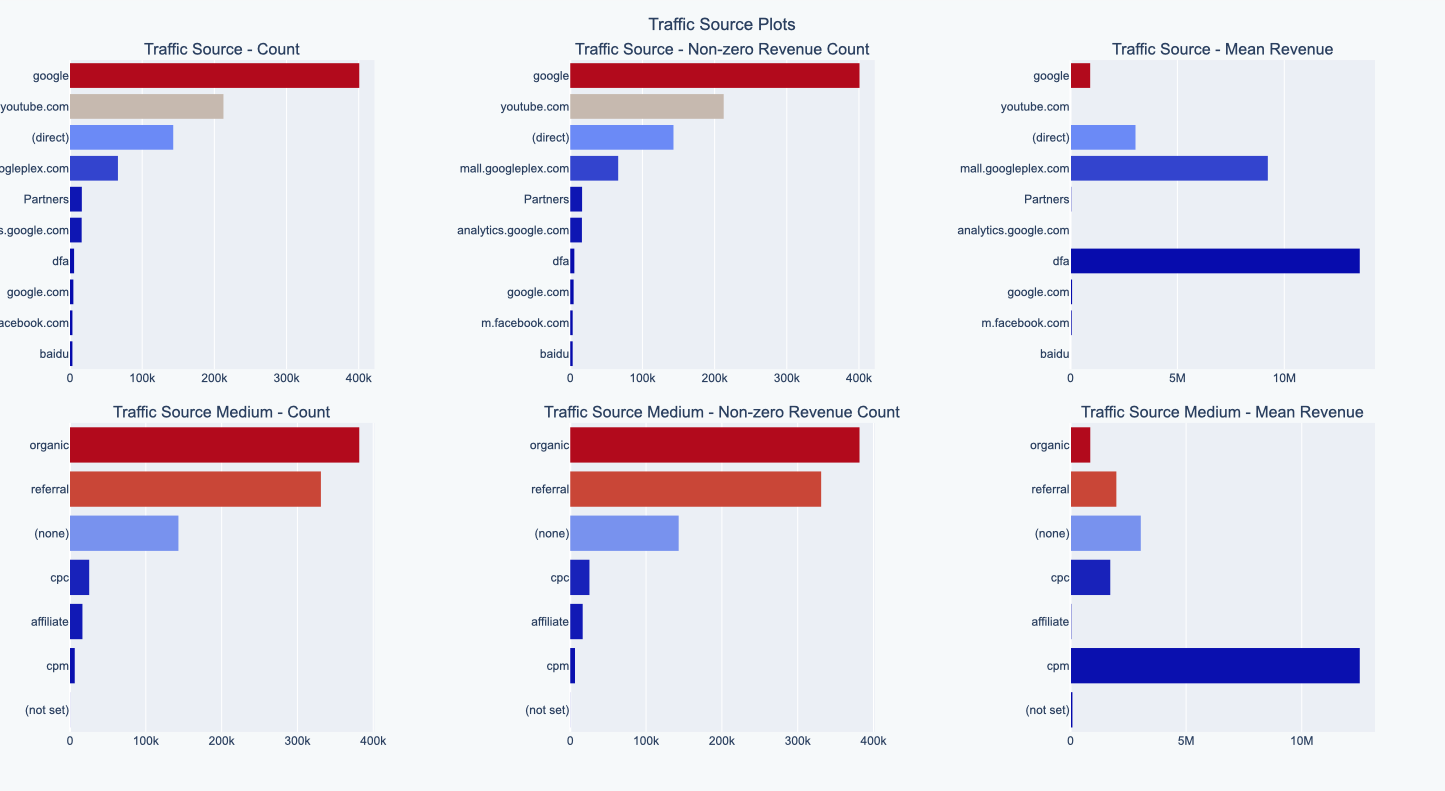

In [17]:
from PIL import Image
import requests
from io import BytesIO
url="https://i.imgsafe.org/85/85cd9c7a7b.png"
response = requests.get(url)
img3 = Image.open(BytesIO(response.content))
img3

In [18]:
# Make traffic source plots
def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace
# Continent
cs = df_train.groupby('trafficSource.source')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cs.columns = ["count", "count of non-zero revenue", "mean"]
cs = cs.sort_values(by="count", ascending=False)
t1 = horizontal_bar_chart(cs["count"].head(10), 'red')
t2 = horizontal_bar_chart(cs["count of non-zero revenue"].head(10), 'red')
t3 = horizontal_bar_chart(cs["mean"].head(10), 'red')

# Sub-continent
cs = df_train.groupby('trafficSource.medium')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cs.columns = ["count", "count of non-zero revenue", "mean"]
cs = cs.sort_values(by="count", ascending=False)
t4 = horizontal_bar_chart(cs["count"], 'blue')
t5 = horizontal_bar_chart(cs["count of non-zero revenue"], 'blue')
t6 = horizontal_bar_chart(cs["mean"], 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Traffic Source - Count", "Traffic Source - Non-zero Revenue Count", "Traffic Source - Mean Revenue",
                                          "Traffic Source Medium - Count",  "Traffic Source Medium - Non-zero Revenue Count", "Traffic Source Medium - Mean Revenue"
                                          ])

fig.append_trace(t1, 1, 1)
fig.append_trace(t2, 1, 2)
fig.append_trace(t3, 1, 3)
fig.append_trace(t4, 2, 1)
fig.append_trace(t5, 2, 2)
fig.append_trace(t6, 2, 3)

fig['layout'].update(height=600, width=1100, paper_bgcolor='rgb(233,233,233)', title="Traffic Source Plots")
iplot(fig, filename='traffic-source-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



#### 5. Boxplot for Device Analysis 
From the boxplot, we see that most customers are using chrome as their purchase browers, no matter what devices they are using. In terms of mean revenue inside the device group, different browsers do not differentiate a lot.

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

invalid value encountered in log1p



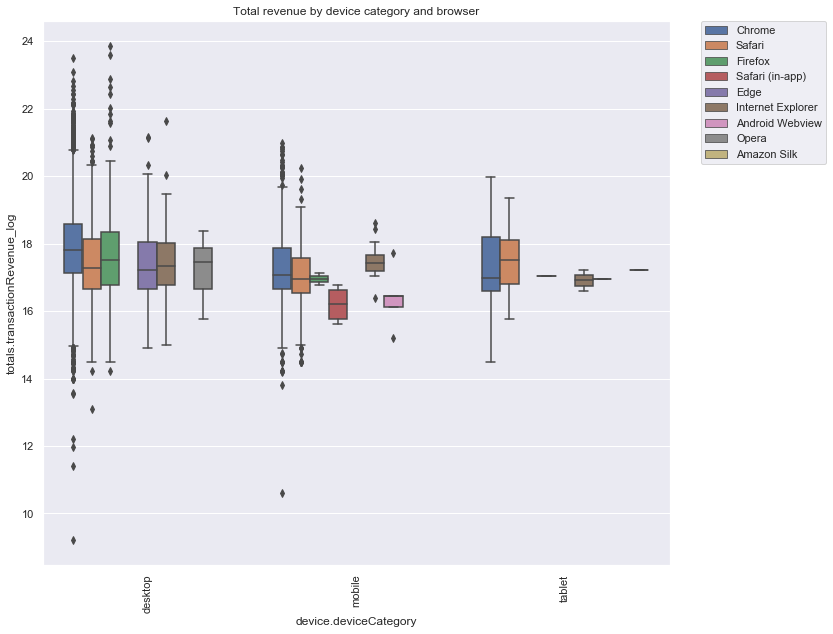

In [19]:
# Make boxplots for transaction revenue for each device category and browser
df_train['totals.transactionRevenue_log'] = np.log1p(df_train['totals.transactionRevenue'])
sns.set(rc={'figure.figsize':(10, 10)})
sns.boxplot(x="device.deviceCategory", y="totals.transactionRevenue_log", hue="device.browser",  data=df_train.loc[df_train['totals.transactionRevenue_log'] > 0.0])
plt.title("Total revenue by device category and browser");
plt.xticks(rotation='vertical')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

#### 6. correlation analysis
Before going to the machine learing step, we'll like to see correlations between some of our numerical columns. It seems that total transaction reveune and visit hour are negatively related.

In [20]:
# Make correlation matrix for important features

df_1 = df_train[['totals.hits','totals.pageviews','totals.transactionRevenue','totals.visits','visitHour','visitNumber']]
corr = df_1.corr()
corr

,totals.hits,totals.pageviews,totals.transactionRevenue,visitHour,visitNumber
totals.hits,1.000000,0.983205,0.141973,0.060964,0.041317
totals.pageviews,0.983205,1.000000,0.128644,0.065887,0.043363
totals.transactionRevenue,0.141973,0.128644,1.000000,-0.015111,0.308895
visitHour,0.060964,0.065887,-0.015111,1.000000,0.019308
visitNumber,0.041317,0.043363,0.308895,0.019308,1.000000


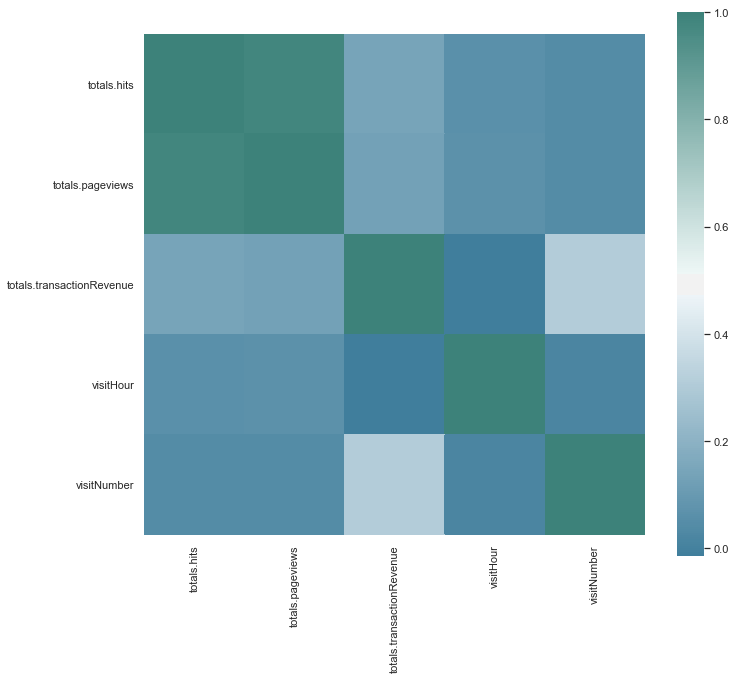

In [21]:
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(230, 180, as_cmap=True),
            square=True)
# plot_corr(df_1,size=5)

#### 7.  Visualization for Visits by date (for train data)

📌note: since we use ploty to generate our result, the picture can not be shown unless you run the code 

📌We have the screenshot attached, and the url link (https://plot.ly/~yz3152/12) to see the animiation version of our picture.

📌Please feel free to click and see details of our visualization!

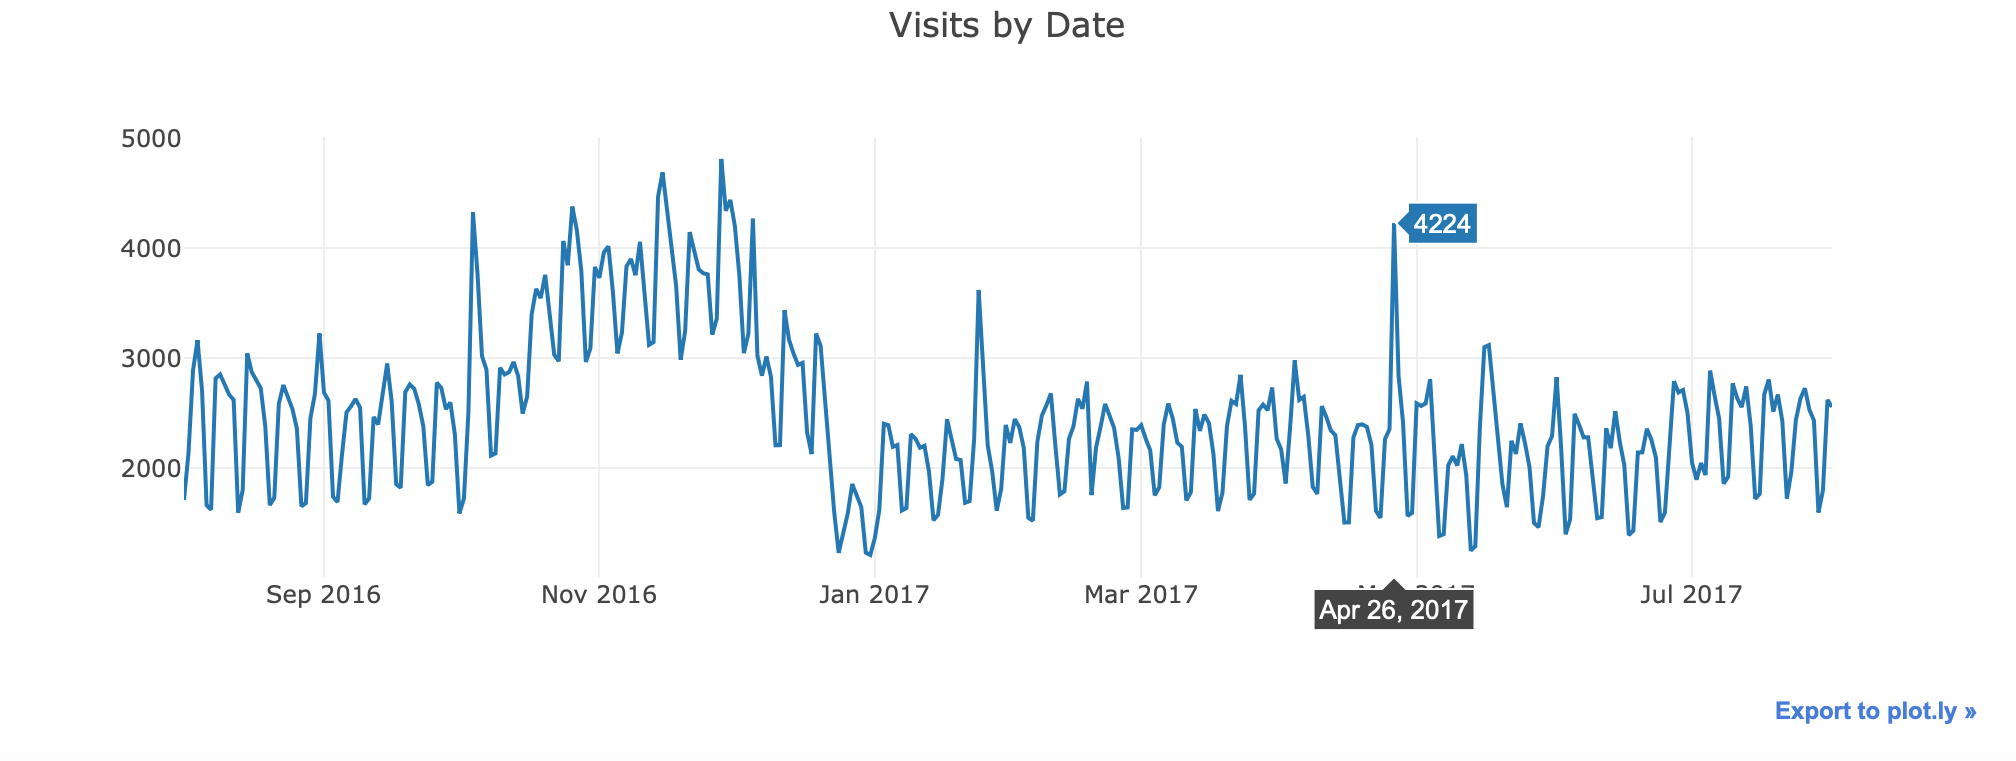

In [28]:
from PIL import Image
import requests
from io import BytesIO
url="https://i.imgsafe.org/94/94518c8868.png"
response = requests.get(url)
img4 = Image.open(BytesIO(response.content))
img4

In [22]:
# Visualization for Visits by date (for train data)
tmp = df_train['date'].value_counts().to_frame().reset_index().sort_values('index')
tmp = tmp.rename(columns = {"index" : "dateX", "date" : "visits"})

tr = go.Scatter(mode="lines", x = tmp["dateX"].astype(str), y = tmp["visits"])
layout = go.Layout(title="Visits by Date", height=400)
fig = go.Figure(data = [tr], layout = layout)
iplot(fig)

#### 8. Monthly log Revenue by Date (Train Data VS Test Data)

📌note: since we use ploty to generate our result, the picture can not be shown unless you run the code 

📌We have the screenshot attached, and the url link (https://plot.ly/~yz3152/16) (https://plot.ly/~yz3152/18) to see the animiation version of our picture.

📌Please feel free to click and see details of our visualization!

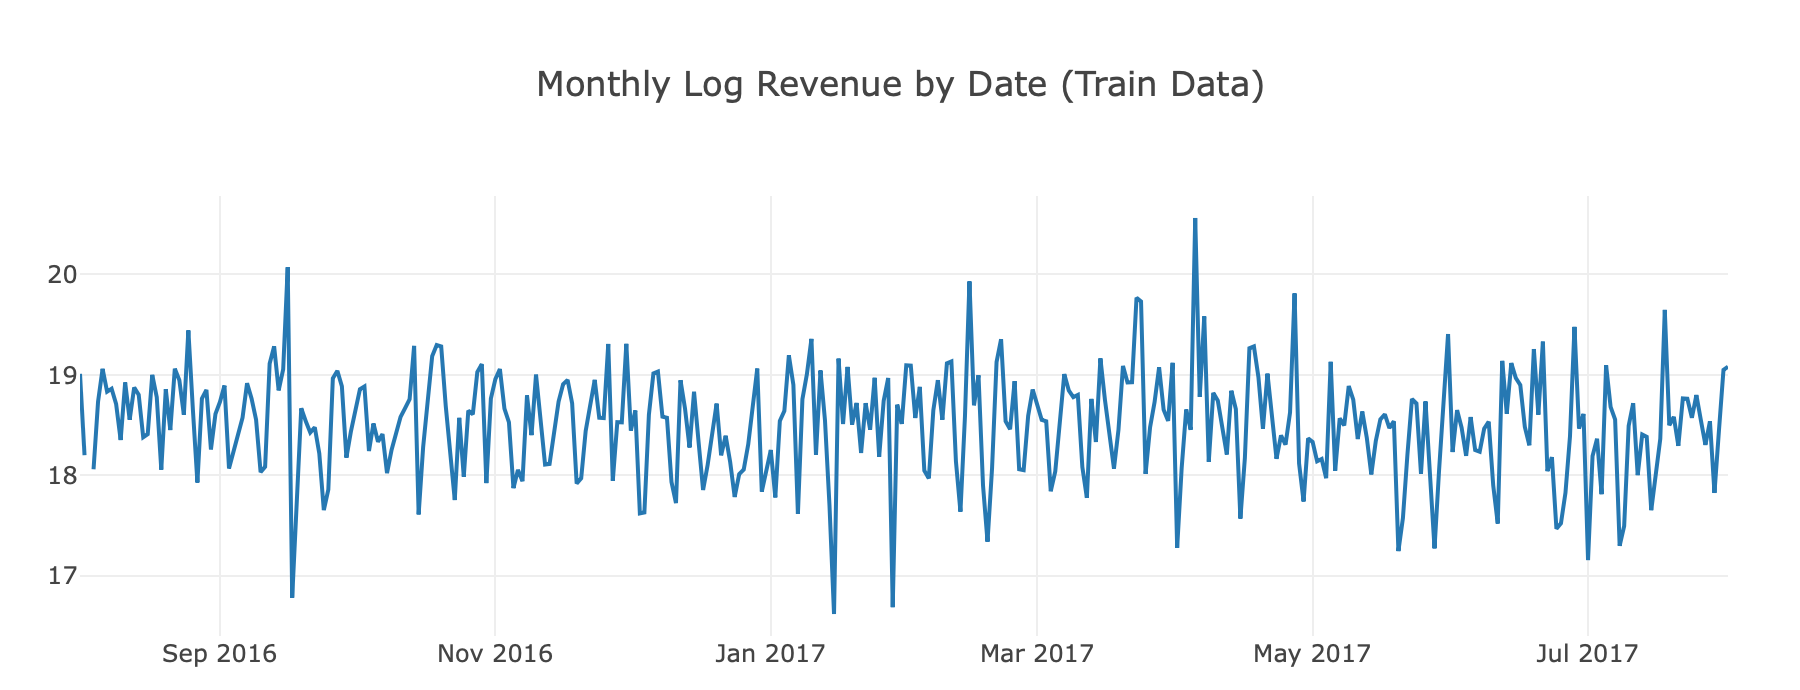

In [35]:
from PIL import Image
import requests
from io import BytesIO
url="https://i.imgsafe.org/94/948f3cce31.png"
response = requests.get(url)
img5 = Image.open(BytesIO(response.content))
img5

In [34]:
# Visualization for Visits by monthly log revenue (for train data)
tmp = df_train.groupby("date").agg({"totals.transactionRevenue" : "mean"}).reset_index()
tmp = tmp.rename(columns = {"date" : "dateX", "totals.transactionRevenue" : "mean_revenue"})
tr = go.Scatter(mode="lines", x = tmp["dateX"].astype(str), y = np.log1p(tmp["mean_revenue"]))
layout = go.Layout(title="Monthly Log Revenue by Date (Train Data) ", height=400)
fig = go.Figure(data = [tr], layout = layout)
iplot(fig)

In [31]:
# Read test data with final prediction output
df_test = pd.read_csv('test_predicted.csv')
df_test = date_process(df_test)

/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.



In [33]:
# Visualization for Visits by monthly revenue (for test data)
tmp_test = df_test.groupby("date").agg({"PredictedRevenue" : "mean"}).reset_index()
tmp_test = tmp_test.rename(columns = {"date" : "dateX", "PredictedRevenue" : "mean_revenue"})
tr = go.Scatter(mode="lines", x = tmp_test["dateX"].astype(str), y = np.log1p(tmp_test["mean_revenue"]))
layout = go.Layout(title="Monthly Revenue by Date (Test Data)", height=400)
fig = go.Figure(data = [tr],layout = layout)
iplot(fig)